In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from astropy.io import ascii
import scipy

In [3]:
all_dr25 = pd.read_csv("result.csv")
selected_stars = all_dr25.where((all_dr25["log(g)"]>4)&(all_dr25["Mass"]<1.2)&(all_dr25["Mass"]>0.8)).dropna(how='all')

data = ascii.read("nph-nstedAPI.txt")  
all_stars = data.to_pandas()
all_stars_in_selected_stars = all_stars[all_stars['kepid'].isin(selected_stars["KIC"])]
all_stars_in_selected_stars = all_stars_in_selected_stars[~np.isnan(all_stars_in_selected_stars["rrmscdpp06p0"])]

In [ ]:

y = torch.load("sims/data_y_mult_hist_fixstars_all")
x = torch.load("sims/data_x_params_fixstars_all")

ynew = torch.load("sims/data_y_mult_hist_fixstars_11")
xnew = torch.load("sims/data_x_params_fixstars_11")

ynew = torch.concatenate((y,ynew),dim=0)
xnew = torch.concatenate((x,xnew),dim=0)


# torch.save(ynew,"sims/data_y_mult_hist_fixstars_all")
# torch.save(xnew,"sims/data_x_params_fixstars_all")

In [27]:
observation, _ = np.histogram(all_stars_in_selected_stars["nconfp"],bins = range(0,12))
N = np.sum(observation)
observation = torch.Tensor(observation/N)
y = torch.load("sims/data_y_mult_hist_fixstars_all")/N
x = torch.load("sims/data_x_params_fixstars_all")

shuffle_mask = torch.randperm(x.size()[0])
x=x[shuffle_mask]
y=y[shuffle_mask]

In [28]:

class Emulator(nn.Module):
    def __init__(self):
        super(Emulator, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(7, 64)     # First hidden layer (input: 5 units, output: 64 units)
        self.fc2 = nn.Linear(64, 128)   # Second hidden layer (input: 64 units, output: 128 units)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)   # Output layer (input: 128 units, output: 33 units)
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, 11)
                             
        # Activation function
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.log_softmax = nn.LogSoftmax()

    def forward(self, x):
        # Pass through the layers with activation
        x = self.relu(self.fc1(x))      # Input to first layer and activation
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)      # Second layer and activation
        x = self.relu(self.fc3(x) )
        x = self.dropout(x)
        x = self.relu(self.fc4(x) )
        x = self.dropout(x)
        x = self.relu(self.fc5(x) )
        x = self.dropout(x)
        x = self.fc6(x)
        x = self.log_softmax(self.fc7(x))        # Output layer (no activation if regression task)
        
        # logits_10 = self.fc7(x)  # 10 logits from the network
        # logit_0 = -torch.exp(torch.logsumexp(logits_10,1,keepdim=True))
    
        # logits_all = torch.cat([logit_0, logits_10], dim=-1)  # Concatenate with the 11th bin
        # log_probs = torch.log_softmax(logits_all, dim=-1)

        return x



model = Emulator()

learning_rate = 0.0005
num_epochs = 800
batch_size = 64
train_size = int(len(x)*0.8)

# Loss and optimizer
#criterion = nn.KLDivLoss(reduction="batchmean",log_target=True)  # Change this if it's a classification problem
#criterion = nn.L1Loss()

def criterion(output,target):
    return -torch.sum((target*output),dim=1)
    
# L2 loss, no softmax

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,100)

inputs = x[:train_size]/100
targets = y[:train_size]
#targets = torch.log(torch.clamp(targets,min = 1/(N*np.e)))

inputs_val = x[train_size:]/100
targets_val = y[train_size:]
#targets_val = torch.log(torch.clamp(targets_val,min = 1/(N*np.e)))

dataset = torch.utils.data.TensorDataset(inputs, targets)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataset_val = torch.utils.data.TensorDataset(inputs_val, targets_val)
data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)




In [95]:
torch.min(targets_val)

tensor(3.4058e-06)

In [96]:
train_losses = []
val_losses = []
min_val_loss = 10000


# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for batch_inputs, batch_targets in data_loader:
        # Forward pass
        outputs = model(batch_inputs)
            
        loss = torch.mean(criterion(outputs, batch_targets),dim=0)
        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the gradients
        
        loss.backward()        # Backpropagation
 
        optimizer.step()       # Update weights
 
        running_loss  += loss.item()
        #scheduler.step()

    running_loss_val  = 0.0

    with torch.no_grad():
        model.eval()
        for batch_inputs, batch_targets in data_loader_val:
            
            outputs = model(batch_inputs)
            loss = torch.mean(criterion(outputs, batch_targets),dim=0)
            running_loss_val  += loss.item()


    train_losses.append(running_loss / len(data_loader))
    val_losses.append(running_loss_val / len(data_loader_val))

    if running_loss_val / len(data_loader_val) < min_val_loss :
        min_val_loss  = running_loss_val / len(data_loader_val)
        best_model  = model
        torch.save(best_model .state_dict(), "best_model_0to10")
    # Print loss for each epoch
    
    avg_loss = running_loss  / len(data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs }], Loss: {avg_loss:.4f}")


print("Training complete!")

c:\Users\vtard\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/800], Loss: 2.2430
Epoch [2/800], Loss: 1.6006
Epoch [3/800], Loss: 0.2905
Epoch [4/800], Loss: 0.2475
Epoch [5/800], Loss: 0.1758
Epoch [6/800], Loss: 0.1658
Epoch [7/800], Loss: 0.1640
Epoch [8/800], Loss: 0.1616
Epoch [9/800], Loss: 0.1613
Epoch [10/800], Loss: 0.1598
Epoch [11/800], Loss: 0.1613
Epoch [12/800], Loss: 0.1606
Epoch [13/800], Loss: 0.1592
Epoch [14/800], Loss: 0.1567
Epoch [15/800], Loss: 0.1568
Epoch [16/800], Loss: 0.1570
Epoch [17/800], Loss: 0.1558
Epoch [18/800], Loss: 0.1559
Epoch [19/800], Loss: 0.1536
Epoch [20/800], Loss: 0.1570
Epoch [21/800], Loss: 0.1534
Epoch [22/800], Loss: 0.1553
Epoch [23/800], Loss: 0.1540
Epoch [24/800], Loss: 0.1535
Epoch [25/800], Loss: 0.1540
Epoch [26/800], Loss: 0.1520
Epoch [27/800], Loss: 0.1523
Epoch [28/800], Loss: 0.1530
Epoch [29/800], Loss: 0.1536
Epoch [30/800], Loss: 0.1522
Epoch [31/800], Loss: 0.1530
Epoch [32/800], Loss: 0.1517
Epoch [33/800], Loss: 0.1515
Epoch [34/800], Loss: 0.1509
Epoch [35/800], Loss: 0

Text(0.5, 0, 'epoch')

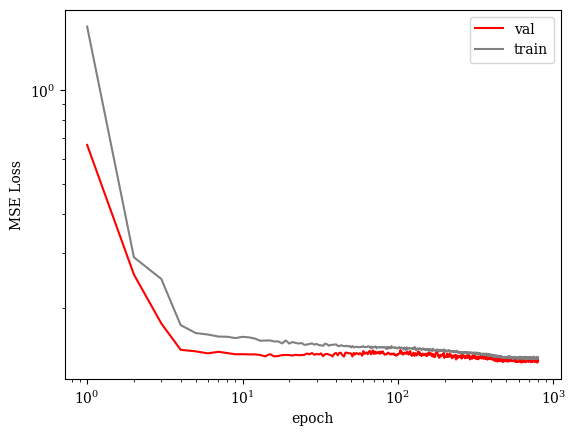

In [97]:
plt.figure()
plt.loglog(range(1,num_epochs),val_losses[1:],color="red",label="val")
plt.loglog(range(1,num_epochs),train_losses[1:],color="gray",label="train")
plt.legend()
plt.ylabel("MSE Loss")
plt.xlabel("epoch")


c:\Users\vtard\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


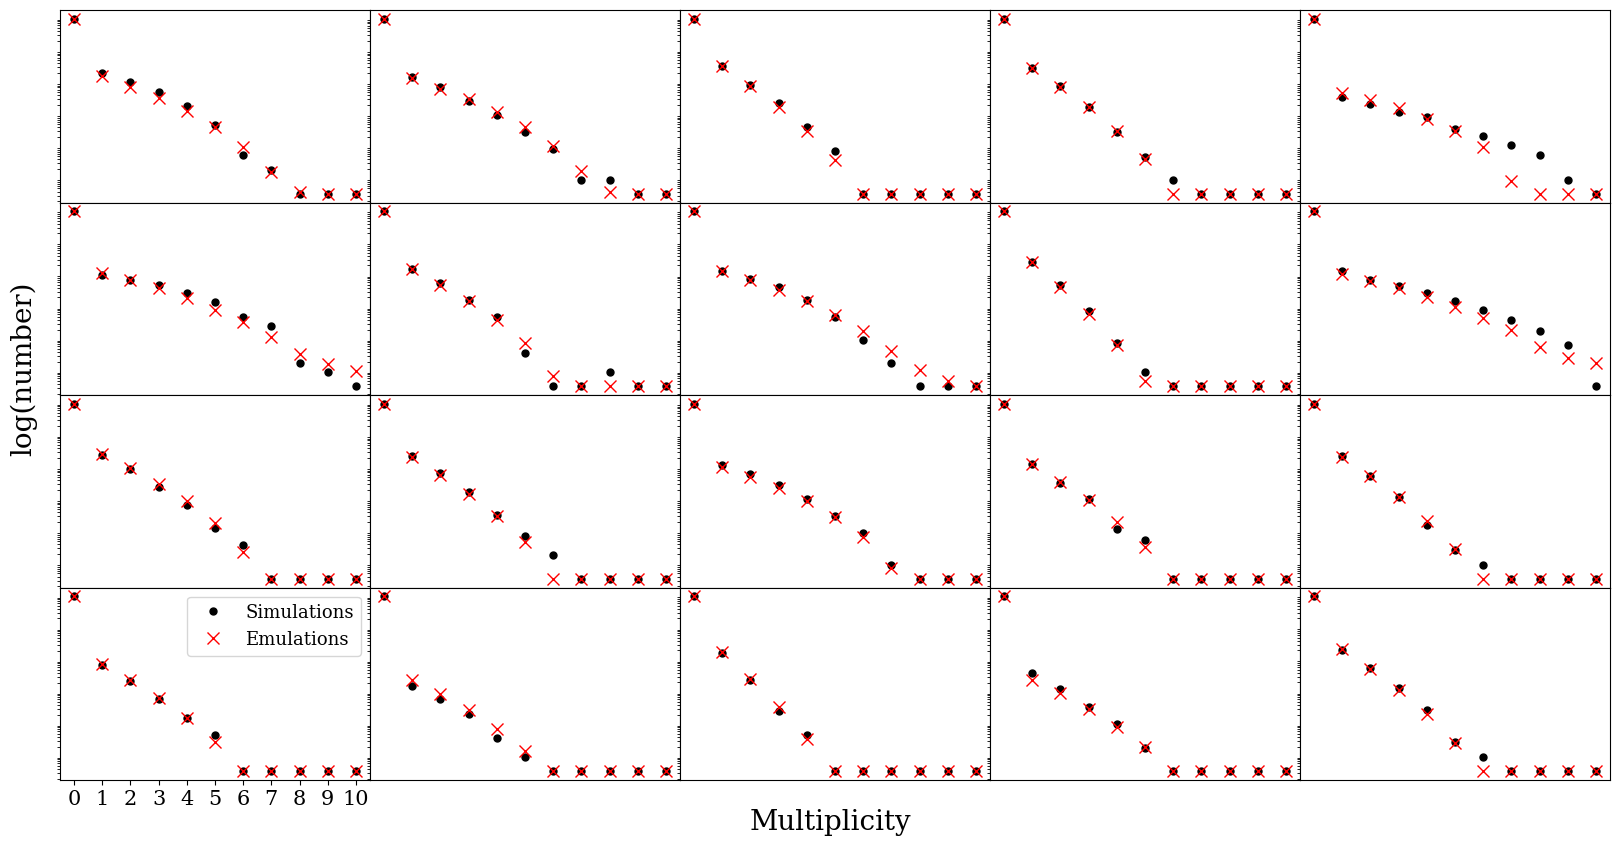

In [29]:
from matplotlib import rcParams

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{cmunitx}'  # Load CMU fonts

model.eval()
model.load_state_dict(torch.load("best_model_0to10", weights_only=True))

#emulated_nozeros = model(inputs_val)
#logr0 = -torch.exp(torch.logsumexp(emulated_nozeros,1,keepdim=False)).detach().numpy()
# emulated_nozeros = emulated_nozeros.detach().numpy()
#emulated = np.concatenate((logr0[:, np.newaxis], emulated_nozeros), axis=1)
simulated = targets_val
simulated[simulated==0.0] = 1/(N*np.e)
emulated = np.exp(model(inputs_val).detach().numpy())
emulated[emulated<1/(N*np.e)] = 1/(N*np.e)


# Create a 4x5 subplot figure
fig, axs = plt.subplots(4, 5, figsize=(20, 10), sharex=False, sharey=False)

# Flatten the axes array for easier iteration
axs = axs.flatten()

# Iterate through the first 20 sets and plot
for i in range(20):
    # Plot the semilogy plot for simulated and emulated data
    
    axs[i].semilogy(range(0, 11), simulated[i], "o",  markersize = 5,color="black",label="Simulations")
    axs[i].semilogy(range(0, 11), emulated[i], "x", markersize = 9,color="red",label="Emulations")

    #axs[i].set_ylim(bottom=-1/np.log(10)-0.5,top=5.4)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
     
axs[-5].legend(loc="upper right",fontsize=13)
plt.subplots_adjust(wspace=0, hspace=0)
axs[-5].set_xticks(range(0,11),range(0,11),fontsize=15)
#axs[-5].set_yticks([0,2,4],[0,2,4],fontsize=15)
fig.text(0.47,0.06,'Multiplicity',fontsize=20)
fig.text(0.1,0.44,'log(number)',fontsize=20,rotation="vertical")
plt.savefig("sim_vs_em.png")


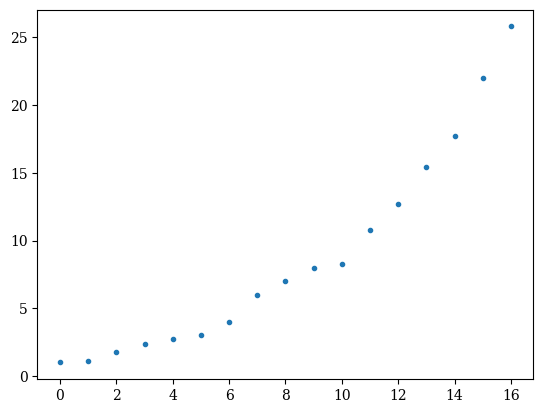

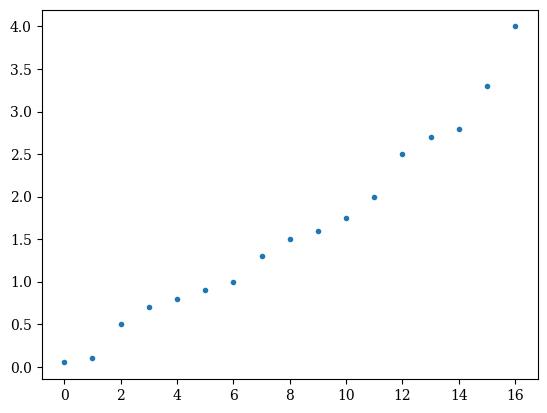

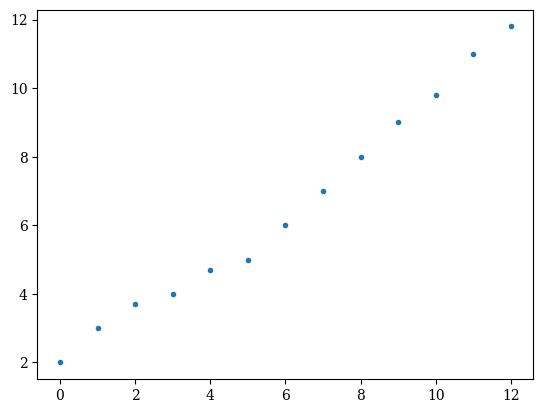

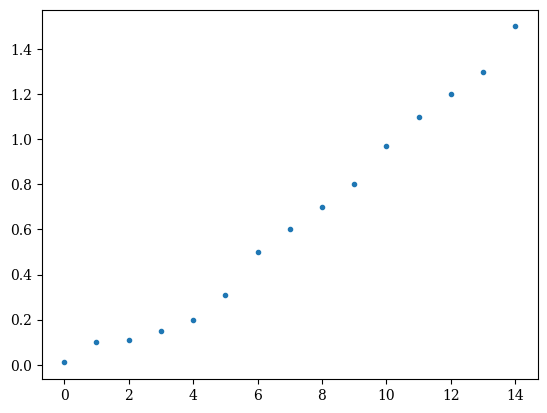

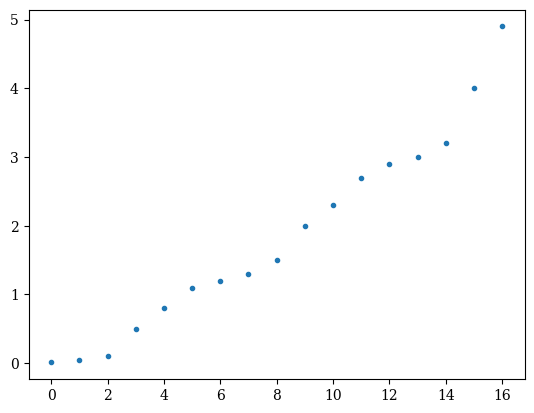

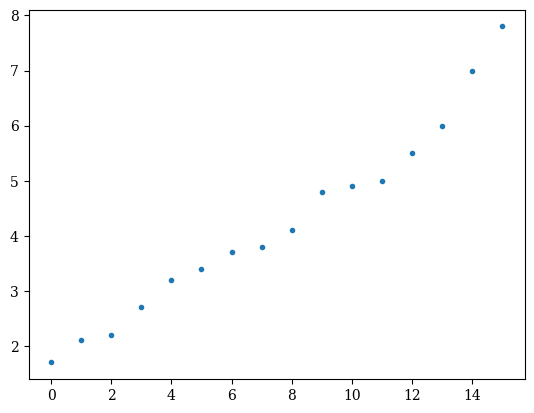

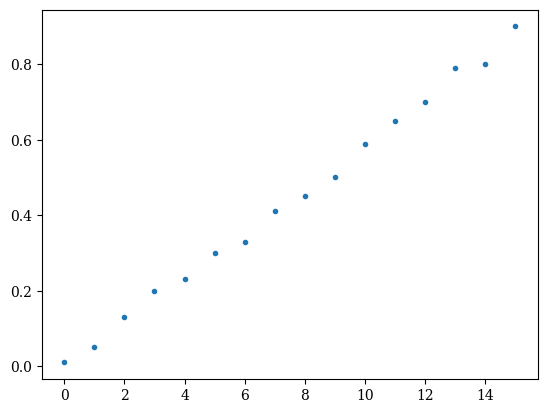

In [14]:
for i in range(7):
 plt.figure()
 plt.plot(torch.unique(x[:,i]),".")

In [16]:
y[:,-1]

tensor([0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000])